In [16]:
import boto3
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
import statsmodels.api as sm
from patsy import dmatrix

from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
bucket_name = 'tfl-cycle-data'
s3_file_path = 'Docking_station_data/Waterloo-Jan2016-Apr2024.pkl'
notebook_file_path = 'temp/Waterloo-Jan2016-Apr2024.pkl'
s3 = boto3.client('s3')

s3.download_file(bucket_name, s3_file_path, notebook_file_path)

In [3]:
with open(notebook_file_path, 'rb') as f:
    waterloo_df = pickle.load(f)

In [4]:
waterloo_df_out = waterloo_df[waterloo_df['Start Station Name'] == 'Waterloo Station 3, Waterloo']
waterloo_df_in = waterloo_df[waterloo_df['End Station Name'] == 'Waterloo Station 3, Waterloo']

waterloo_df_out.head()

,Rental ID,Start Date,Start Station Name,End Date,End Station Name
4,50756101,2016-10-01 10:12:00,"Waterloo Station 3, Waterloo",2016-10-01 10:27:00,"Braham Street, Aldgate"
7,50758609,2016-10-01 12:24:00,"Waterloo Station 3, Waterloo",2016-10-01 12:39:00,"Kennington Oval, Oval"
8,50759951,2016-10-01 13:10:00,"Waterloo Station 3, Waterloo",2016-10-01 13:56:00,"Eversholt Street , Camden Town"
9,50759954,2016-10-01 13:10:00,"Waterloo Station 3, Waterloo",2016-10-01 13:56:00,"Eversholt Street , Camden Town"
10,50759977,2016-10-01 13:11:00,"Waterloo Station 3, Waterloo",2016-10-01 13:56:00,"Eversholt Street , Camden Town"


In [5]:
waterloo_df_out = waterloo_df[waterloo_df['Start Station Name'] == 'Waterloo Station 3, Waterloo']

waterloo_df_out.set_index('Start Date', inplace=True)
rentals_5min = waterloo_df_out.resample('5min').size().reset_index(name='Rentals')

rentals_5min.head(10)

,Start Date,Rentals
0,2015-01-02 01:45:00,1
1,2015-01-02 01:50:00,0
2,2015-01-02 01:55:00,0
3,2015-01-02 02:00:00,0
4,2015-01-02 02:05:00,0
5,2015-01-02 02:10:00,0
6,2015-01-02 02:15:00,0
7,2015-01-02 02:20:00,0
8,2015-01-02 02:25:00,0
9,2015-01-02 02:30:00,0


In [19]:
rentals_5min['hour'] = rentals_5min['Start Date'].dt.hour.astype('category')
rentals_5min['day_of_week'] = rentals_5min['Start Date'].dt.dayofweek.astype('category')
rentals_5min['month'] = rentals_5min['Start Date'].dt.month.astype('category')

rentals_5min.head()

,Start Date,Rentals,hour,day_of_week,month,predicted_rentals
0,2015-01-02 01:45:00,1,1,4,1,0.542547
1,2015-01-02 01:50:00,0,1,4,1,0.542547
2,2015-01-02 01:55:00,0,1,4,1,0.542547
3,2015-01-02 02:00:00,0,2,4,1,0.542331
4,2015-01-02 02:05:00,0,2,4,1,0.542331


In [7]:
X = rentals_5min[['hour', 'day_of_week', 'month']]
y = rentals_5min['Rentals']

In [20]:
# Define a column transformer to one-hot encode categorical features
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), ['hour', 'day_of_week', 'month'])
    ],
    remainder='passthrough'
)

# Create a pipeline with the column transformer and Poisson regressor
model = Pipeline(steps=[
    # ('preprocessor', column_transformer),
    ('regressor', PoissonRegressor())
])

# Fit the model
model.fit(X, y)

Pipeline(steps=[('regressor', PoissonRegressor())])

Intercept: 0.14490995572931742
Coefficients: [-0.05350978 -0.09970182  0.01270361]


(19150.208333333332, 19151.0)

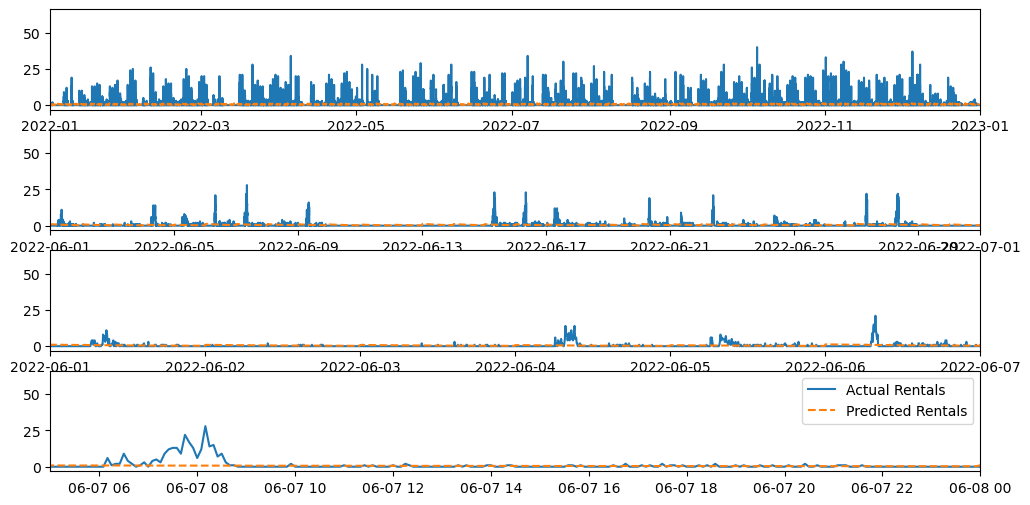

In [35]:

# Predict the rentals
rentals_5min['predicted_rentals'] = model.predict(X)

# Print model coefficients
regressor = model.named_steps['regressor']
print(f'Intercept: {regressor.intercept_}')
print(f'Coefficients: {regressor.coef_}')

# Plot the actual vs predicted rentals
fig, axs = plt.subplots(4,1, figsize=(12, 6))
for ax in axs:
    ax.plot(rentals_5min['Start Date'], rentals_5min['Rentals'], label='Actual Rentals')
    ax.plot(rentals_5min['Start Date'], rentals_5min['predicted_rentals'], label='Predicted Rentals', linestyle='--')
    # ax.xlabel('Date')
    # ax.ylabel('Number of Rentals')
    # ax.title('Actual vs Predicted Rentals')
plt.legend()
axs[0].set_xlim(pd.to_datetime('2022-01-01 00:00:00'), pd.to_datetime('2023-01-01 00:00:00'))
axs[1].set_xlim(pd.to_datetime('2022-06-01 00:00:00'), pd.to_datetime('2022-07-01 00:00:00'))
axs[2].set_xlim(pd.to_datetime('2022-06-01 00:00:00'), pd.to_datetime('2022-06-07 00:00:00'))
axs[3].set_xlim(pd.to_datetime('2022-06-07 05:00:00'), pd.to_datetime('2022-06-8 00:00:00'))